In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install -q torchvision
import torch
import torchvision
import torchvision.transforms as T
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models import resnet50
import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
from torchvision.models import resnet50
from torchvision.ops import box_iou
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import matplotlib.patches as patches
import albumentations as A
from albumentations.pytorch import ToTensorV2

# DETECTION MODEL FASTER RCNN

In [ ]:
class LungTumorDataset(Dataset):
    def __init__(self, image_dir, detection_dir, mask_dir, transforms=None):
        self.image_paths = []
        self.label_paths = []
        self.mask_paths = []
        self.transforms = transforms

        subject_dirs = sorted(os.listdir(image_dir))
        for subject in subject_dirs:
            subject_img_dir = os.path.join(image_dir, subject)
            subject_lbl_dir = os.path.join(detection_dir, subject)
            subject_mask_dir = os.path.join(mask_dir, subject)

            for img_name in sorted(os.listdir(subject_img_dir)):
                img_path = os.path.join(subject_img_dir, img_name)
                label_name = os.path.splitext(img_name)[0] + ".txt"
                label_path = os.path.join(subject_lbl_dir, label_name)
                mask_path = os.path.join(subject_mask_dir, img_name)

                self.image_paths.append(img_path)
                self.label_paths.append(label_path)
                self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        mask_path = self.mask_paths[idx]

        img = np.array(Image.open(img_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    x_min, y_min, x_max, y_max = map(float, parts)
                    boxes.append([x_min, y_min, x_max, y_max])

        # Apply Albumentations transform using keyword arguments
        if self.transforms:
            transformed = self.transforms(image=img, bboxes=boxes, masks=[mask])
            img = transformed['image']
            boxes = transformed['bboxes']
            mask = transformed['masks'][0]
        if img.dtype == torch.uint8:
            img = img.float() / 255.0

        if not isinstance(boxes, torch.Tensor):
            boxes = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64) if len(boxes) > 0 else torch.zeros((0,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return img, target, mask

In [ ]:
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, p=0.5),
    A.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), size=(256, 256), p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=[]))

def collate_fn(batch):
    return tuple(zip(*batch))

train_img_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/train/images'
train_detection_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/train/detections'
train_mask_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/train/masks'


train_dataset = LungTumorDataset(train_img_dir, train_detection_dir, train_mask_dir, transforms=albumentations_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
print("Dataset and DataLoader created successfully.")

Dataset and DataLoader created successfully.


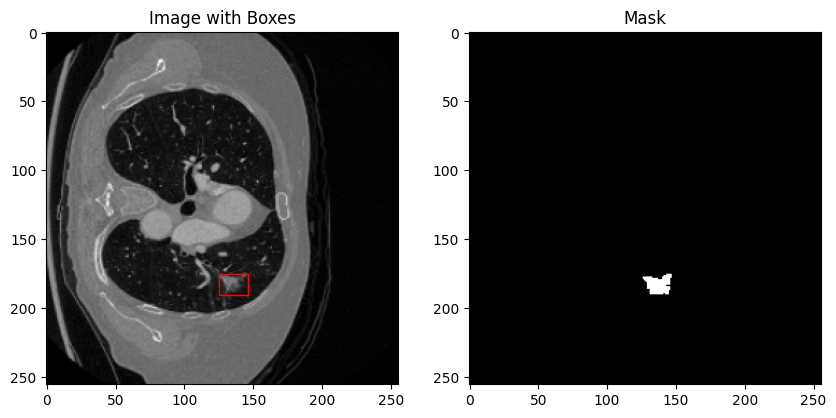

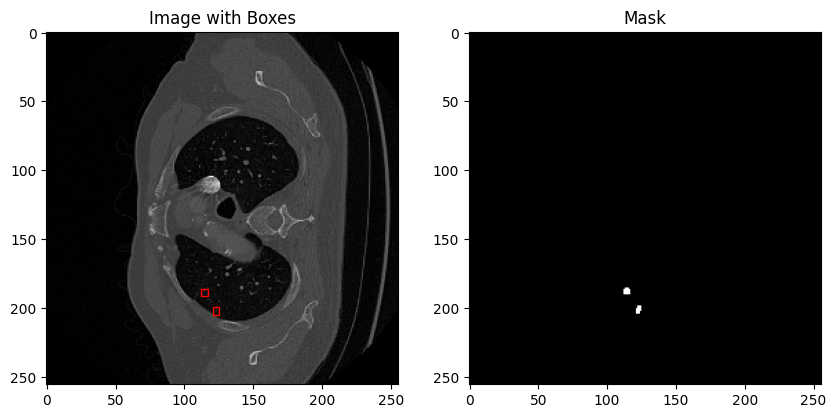

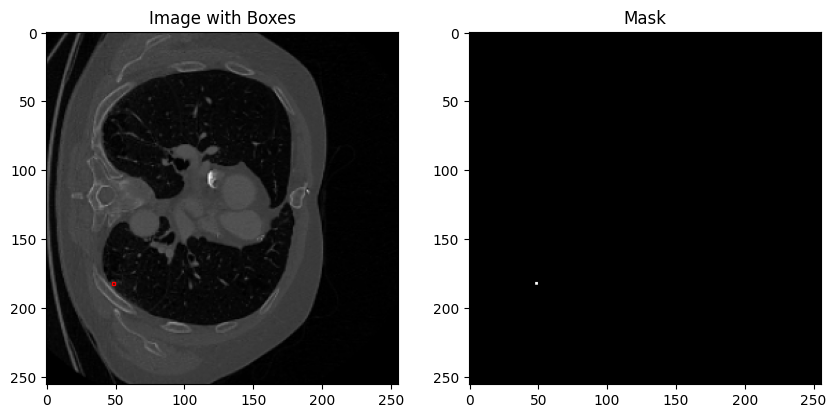

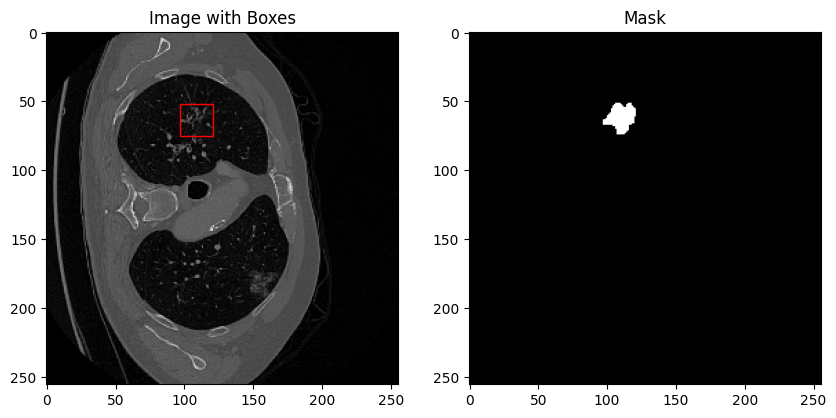

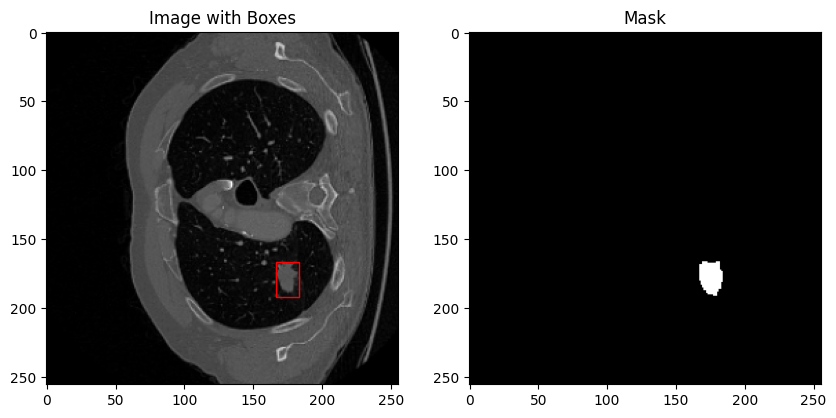

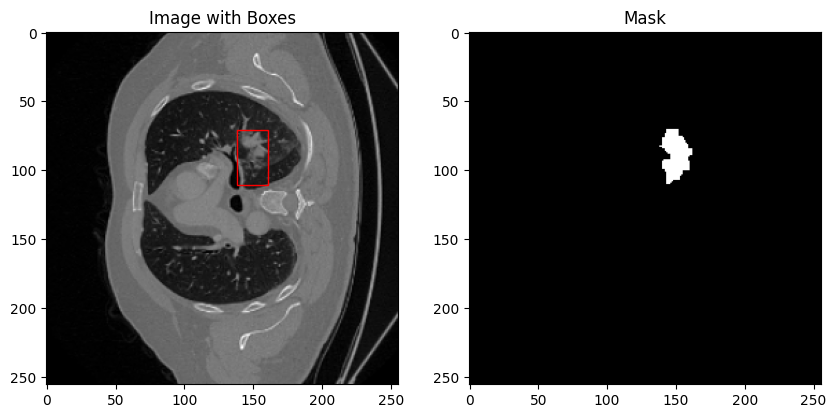

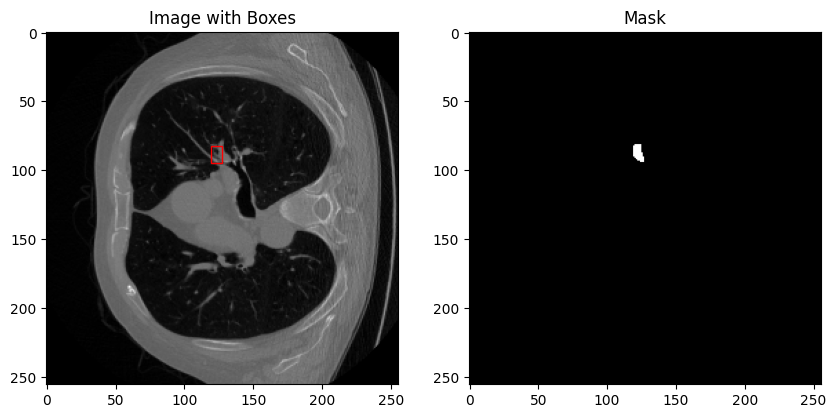

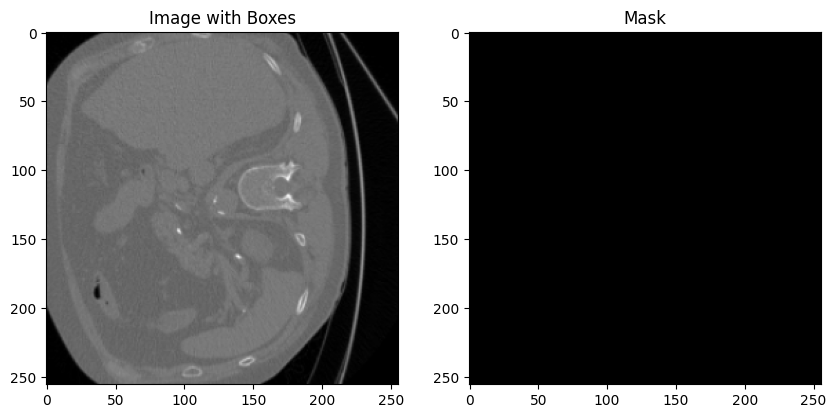

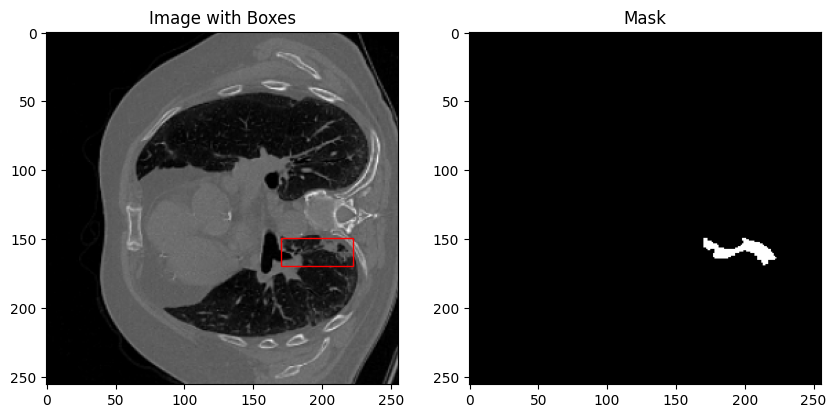

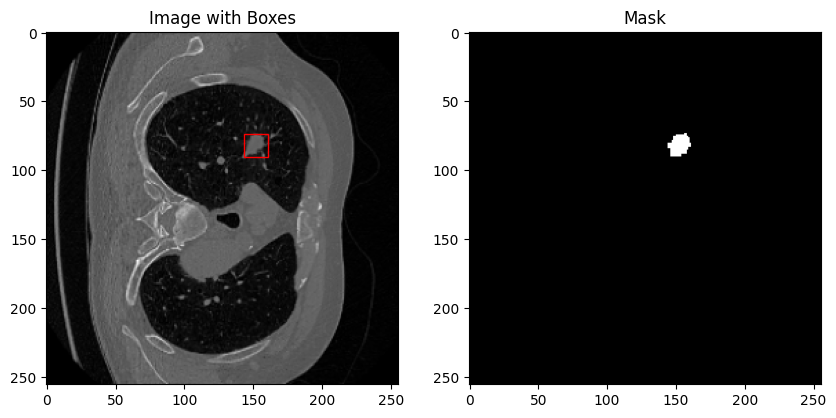

In [ ]:
# Load a single batch
for images, targets, masks in train_loader:
    for i in range(10):  # Show 4 samples
        img = images[i]
        target = targets[i]
        mask = masks[i]

        # Convert tensor to numpy for plotting
        img_np = img.permute(1, 2, 0).numpy()
        mask_np = mask.squeeze().numpy()

        # Plot image and mask
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img_np, cmap='gray')
        ax[0].set_title('Image with Boxes')

        # Draw bounding boxes
        for box in target['boxes']:
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red')
            ax[0].add_patch(rect)

        ax[1].imshow(mask_np, cmap='gray')
        ax[1].set_title('Mask')
        plt.show()

    break  # Only one batch


In [ ]:
val_img_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/val/images'
val_detection_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/val/detections'
val_mask_dir = '/content/drive/My Drive/LungTumorDetectionAndSegmentation/val/masks'

val_dataset = LungTumorDataset(val_img_dir, val_detection_dir, val_mask_dir, transforms=albumentations_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
class FasterRCNNFromScratch(nn.Module):
    def __init__(self, num_classes=2):  # 1 class (signature) + background
        super(FasterRCNNFromScratch, self).__init__()

        # Backbone: ResNet50 without pretrained weights
        resnet = resnet50(weights=None)
        # Keeps only convolutional layers as a feature extractor.
        return_nodes = {"layer4": "0"}
        self.backbone = create_feature_extractor(resnet, return_nodes=return_nodes)
        self.backbone.out_channels = 256

        # RPN anchor generator
        anchor_generator = AnchorGenerator(
            sizes=((8, 16, 32, 64, 128),),
            aspect_ratios=((0.5, 1.0, 2.0),)
        )

        # ROI Pooler
        roi_pooler = MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )

        # Final model
        self.model = FasterRCNN(
            backbone=self.backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )

        self._initialize_weights()

    def forward(self, images, targets=None):
        return self.model(images, targets) if self.training else self.model(images)

    def _initialize_weights(self):
        for m in self.backbone.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [ ]:
# Example usage
model = FasterRCNNFromScratch(num_classes=2).to("cuda")
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

patience = 3  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_no_improve = 0

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (images, targets, masks) in enumerate(tqdm(train_loader)):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Check for NaN in loss
        if torch.isnan(losses):
            print(f"\nNaN loss detected at epoch {epoch+1}, batch {batch_idx+1}")
            print("Loss dict:", loss_dict)
            print("Targets:", targets)
            break

        epoch_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Save model after each epoch
    torch.save(model.state_dict(), f"fasterrcnn_lungtumor_epoch{epoch+1}.pth")


  0%|          | 0/1832 [00:00<?, ?it/s]C:\Users\mazen\AppData\Local\Temp\ipykernel_24852\3628649712.py:62: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.as_tensor(labels_list, dtype=torch.int64)
100%|██████████| 1832/1832 [04:30<00:00,  6.77it/s]


Epoch 1/10, Loss: 517.8453


100%|██████████| 1832/1832 [04:35<00:00,  6.64it/s]


Epoch 2/10, Loss: 433.8614


100%|██████████| 1832/1832 [04:32<00:00,  6.72it/s]


Epoch 3/10, Loss: 403.3423


100%|██████████| 1832/1832 [04:32<00:00,  6.73it/s]


Epoch 4/10, Loss: 393.4441


100%|██████████| 1832/1832 [04:31<00:00,  6.74it/s]


Epoch 5/10, Loss: 392.5530


100%|██████████| 1832/1832 [04:31<00:00,  6.75it/s]


Epoch 6/10, Loss: 337.2141


100%|██████████| 1832/1832 [04:32<00:00,  6.72it/s]


Epoch 7/10, Loss: 318.9945


100%|██████████| 1832/1832 [04:32<00:00,  6.73it/s]


Epoch 8/10, Loss: 303.5452


100%|██████████| 1832/1832 [04:32<00:00,  6.73it/s]


Epoch 9/10, Loss: 293.4381


100%|██████████| 1832/1832 [04:34<00:00,  6.68it/s]


Epoch 10/10, Loss: 287.5633


In [ ]:
def compute_iou(box1, box2):
    """Computes IoU between two boxes."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection

    if union == 0:
        return 0.0
    return intersection / union

def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    total_gt = 0
    total_matched = 0

    with torch.no_grad():
        for images, targets, _ in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_boxes = target['boxes'].cpu()
                pred_boxes = output['boxes'].cpu()

                total_gt += len(gt_boxes)
                matched_gt = set()

                for pred_box in pred_boxes:
                    for i, gt_box in enumerate(gt_boxes):
                        if i in matched_gt:
                            continue
                        if compute_iou(pred_box, gt_box) >= iou_threshold:
                            total_matched += 1
                            matched_gt.add(i)
                            break

    accuracy = total_matched / total_gt if total_gt > 0 else 0
    print(f"Simplified Accuracy (IoU > {iou_threshold}): {accuracy:.4f}")
    return accuracy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
evaluate_model(model, val_loader, device)

Evaluating:   1%|          | 1/98 [00:00<00:37,  2.59it/s]C:\Users\mazen\AppData\Local\Temp\ipykernel_13472\3628649712.py:62: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  labels = torch.as_tensor(labels_list, dtype=torch.int64)
Evaluating: 100%|██████████| 98/98 [00:06<00:00, 14.35it/s]

Simplified Accuracy (IoU > 0): 0.9302


0.9302325581395349

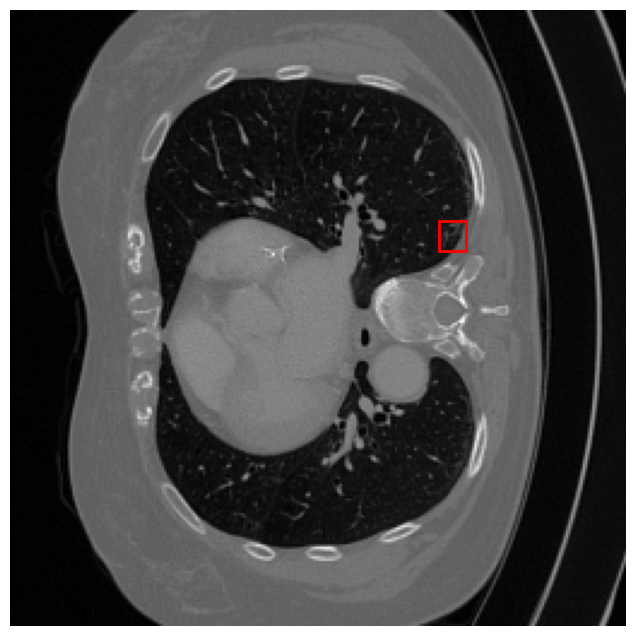

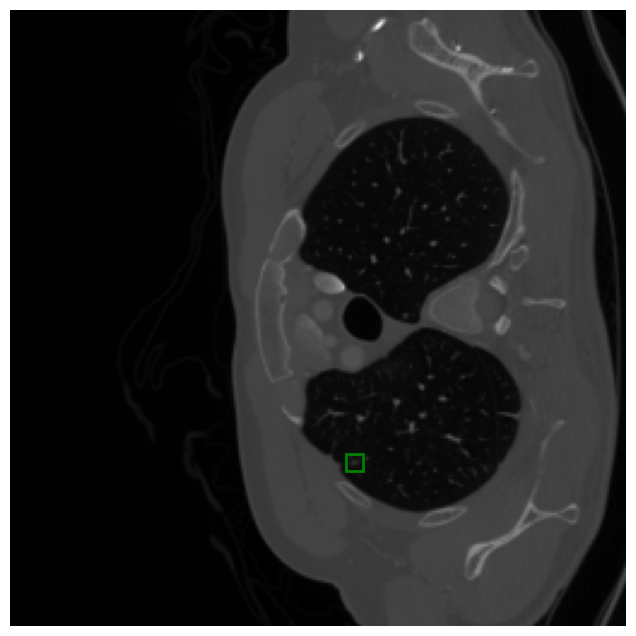

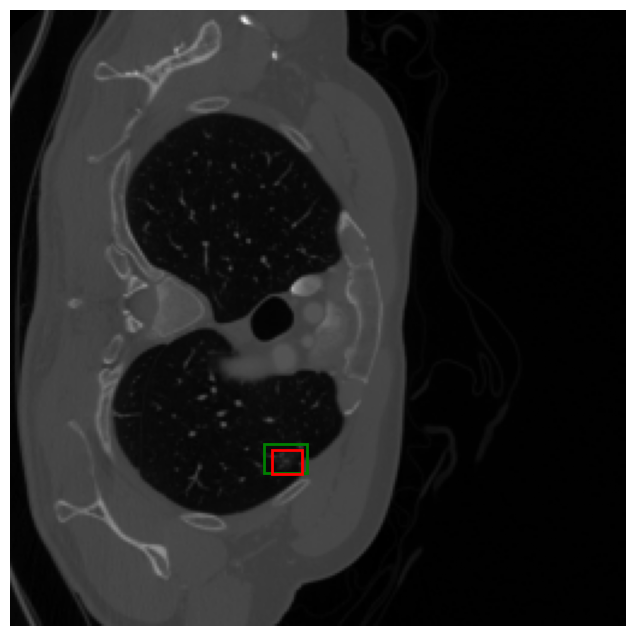

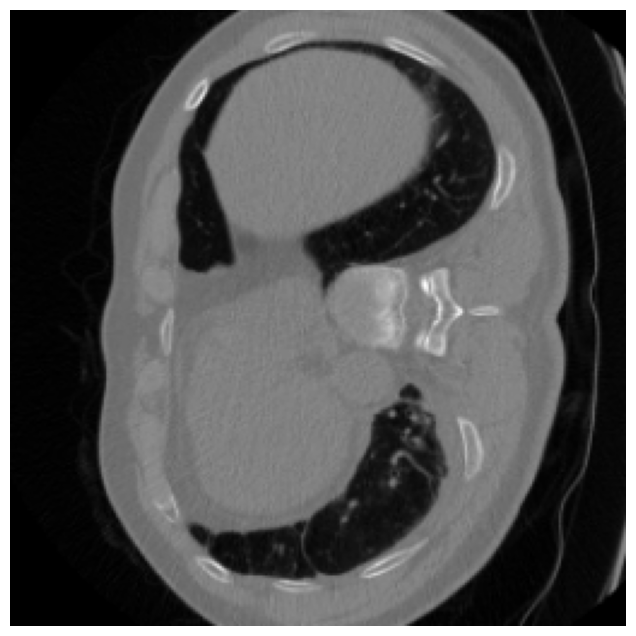

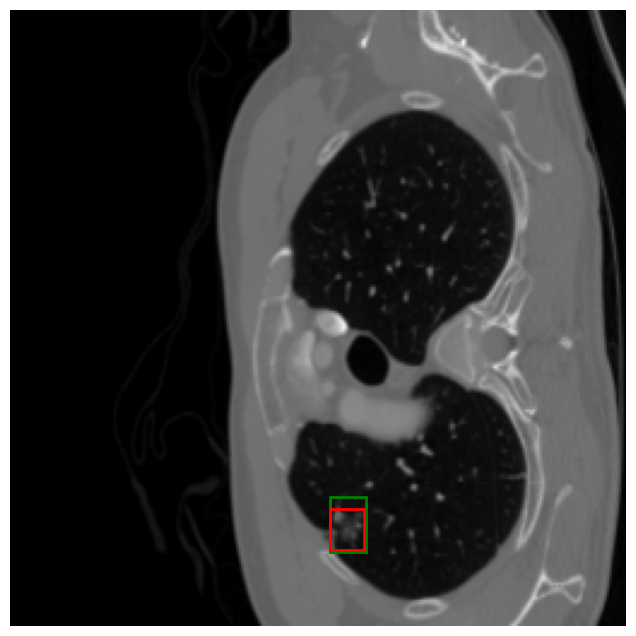

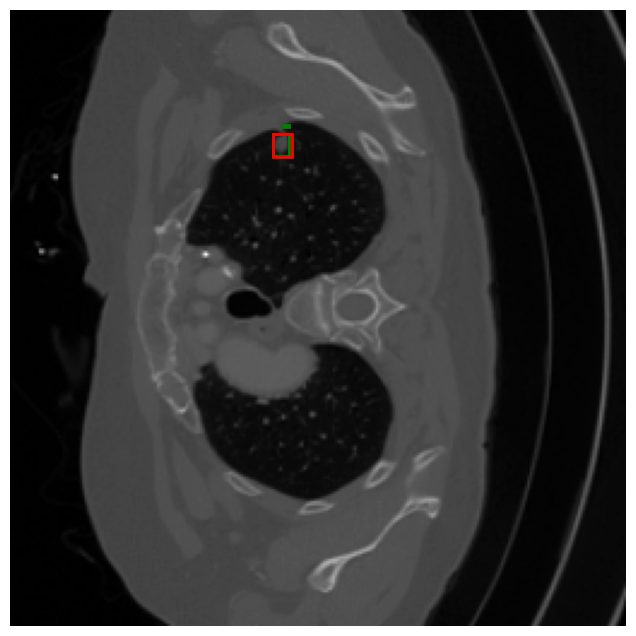

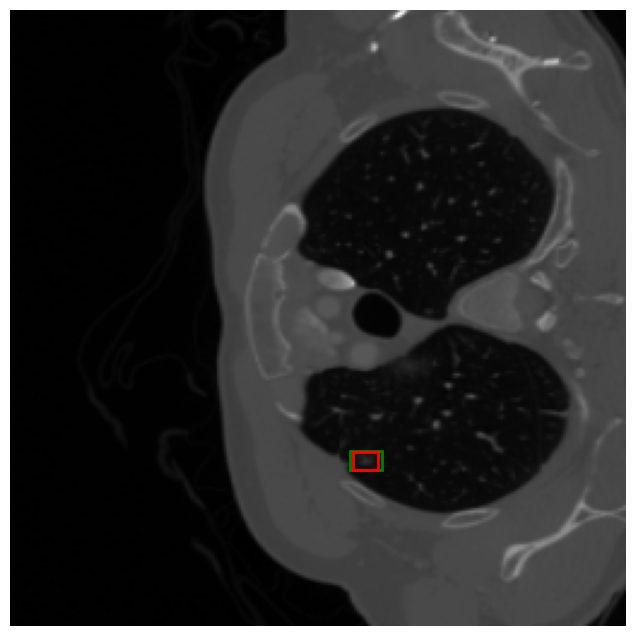

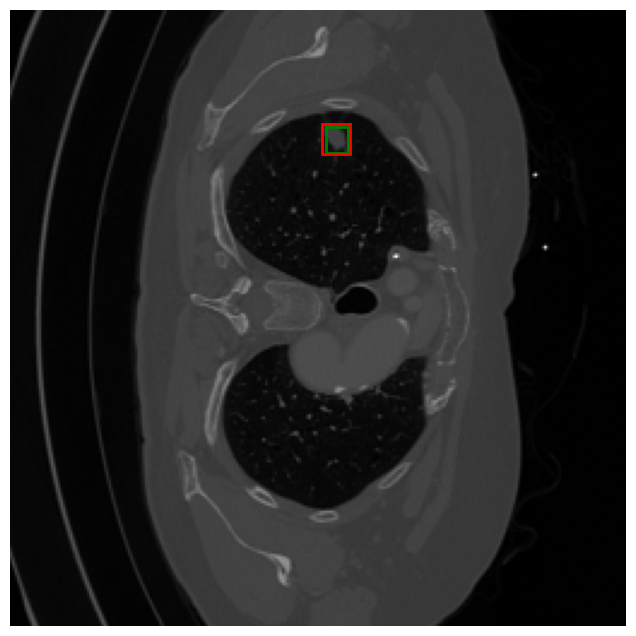

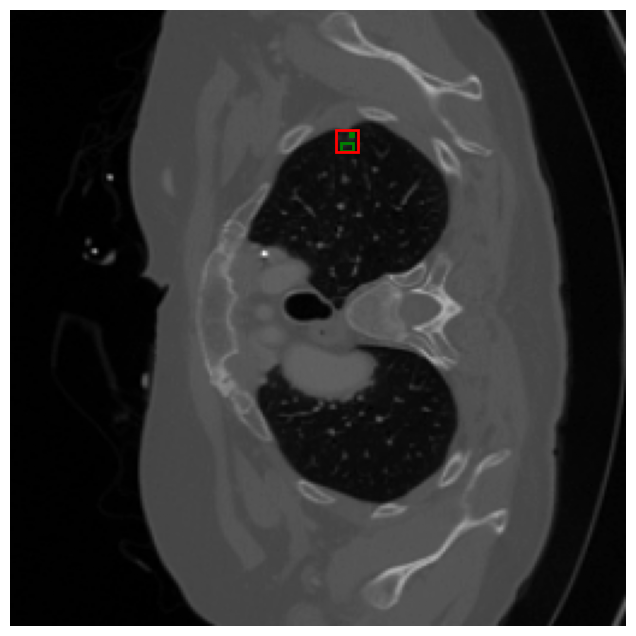

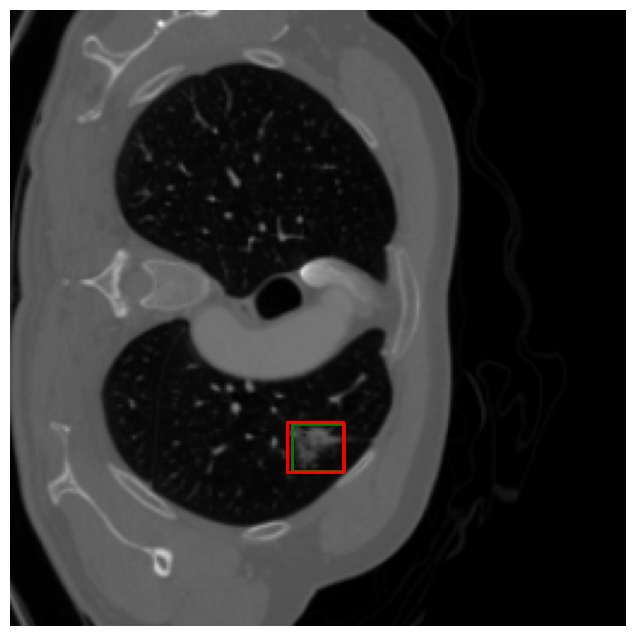

In [ ]:
def show_gt_and_preds(image, gt_boxes, pred_boxes):
    image_np = image.mul(255).byte().cpu().numpy().transpose(1, 2, 0)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(image_np.squeeze(), cmap='gray')

    # Green = Ground Truth
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    # Red = Predictions
    for box in pred_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Set model to evaluation mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loop through evaluation dataset
with torch.no_grad():
    for i, (images, targets, masks) in enumerate(val_loader):  # or val_loader
        if i >= 10:
            break
        images = [img.to(device) for img in images]
        outputs = model(images)

        for img, target, output in zip(images, targets, outputs):
            gt_boxes = target['boxes'].cpu()
            pred_boxes = output['boxes'][output['scores'] > 0.5].cpu()
            show_gt_and_preds(img.cpu(), gt_boxes, pred_boxes)
